# Analyzing performance of Shape Predictor

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import statistics

In [19]:
def read_lmfile(inputfile):
        
        """Parse tps or txt file that contains landmarks
        
        Returns:
            self.lm_dict (Dict): Dictionary that contains flip_images (basename) as keys and landmarks as values
            self.img_list (List): List of flip_images (basename)
            Landmarks.nested_dict (Dict): Nested Dictionary with ID, SCALE and LM for every image (og_name)
        """
        landmarks_dict = {}
        landmarks = []
        image_list = []
        check = False
        with open(inputfile, 'r') as file:
      
            for line in file:
                
                # Process expected line, "LANDMARKS" 
                if line.startswith("LM"):
                    n_lm = int(line.strip().split('=')[1])
                    
                    if n_lm == 0:
                        print(f"WARNING: No landmarks annotated for this image")
                    
                    # Read all the landmarks
                    else: 
                        check = False
                        i = 0
                        lm_list = []
                        while i < n_lm:
                            landmark_line = next(file).strip().split() 
                            lm = [float(landmark_line[0]), float(landmark_line[1])]
                            lm_list.append(lm)
                            i+=1
                    if n_lm != 12:
                        print(f"What the fuck happens here")
                        check = True
                    else: 
                        check = False
                        

                    # Process the next expected line, "IMAGE"
                    next_line = file.readline()
                    
                    if next_line.startswith("IMAGE"):
                        image_name = str(next_line.strip().split('=')[1])
                        image_list.append(image_name)
                        landmarks_dict[image_name] = {}
                        landmarks.append(lm_list)
                        if check == True:
                            print(f'Image {image_name} has only {n_lm} landmarks annotated')
                        else:
                            for i, lm in enumerate(lm_list):
                                landmarks_dict[image_name][i] = lm
                                            
                    # Process the next expected line, "ID"
                    next_line = file.readline()
                    
                    if next_line.startswith("ID"):
                        real_id = str(next_line.strip().split('=')[1])
                    
                    # Process the next expected line, "SCALE"
                    next_line = file.readline()
                    
                    if next_line.startswith("SCALE"):
                        scale = next_line.strip()
        
        return np.array(landmarks), image_list, dict(sorted(landmarks_dict.items()))

In [20]:
prediction_file = '/Users/luciamf/Desktop/Landmarks_generator/example/carabus_1_landmarks/carabus_1_landmarks.txt'
train_file = '/Users/luciamf/Desktop/Landmarks_generator/example/Carabus_pronotum_train.txt'

In [21]:
pred_landmarks, image_pred, pred_dict = read_lmfile(prediction_file)
real_landmarks, image_real, real_dict = read_lmfile(train_file)

In [22]:
len(pred_landmarks), len(real_landmarks),len(image_real), len(image_pred)

(319, 319, 319, 319)

In [23]:
def get_xy(landmarks):
    x_list = []
    y_list = []
    for coor in landmarks:
        for x,y in coor:
            x_list.append(x)
            y_list.append(y)
    return x_list,y_list

set 1: [[1131. 1774.]
 [1738. 1719.]
 [2727.  616.]
 [1763.  524.]
 [2331. 1779.]
 [2542.  261.]
 [ 977.  258.]
 [1355.  510.]
 [2166.  501.]
 [ 777. 1445.]
 [2708. 1447.]
 [ 763.  644.]]
set 2: [[1152. 1770.]
 [1741. 1712.]
 [2325. 1777.]
 [2543.  257.]
 [ 959.  259.]
 [1367.  519.]
 [2121.  519.]
 [ 836. 1538.]
 [2678. 1494.]
 [ 757.  691.]
 [2750.  698.]
 [1748.  508.]]
set 1: [[1203. 1749.]
 [1811. 1722.]
 [2835.  799.]
 [1789.  455.]
 [2449. 1729.]
 [2567.  251.]
 [ 996.  290.]
 [1369.  468.]
 [2202.  439.]
 [ 897. 1529.]
 [2751. 1485.]
 [ 765.  876.]]
set 2: [[1199. 1749.]
 [1806. 1726.]
 [2453. 1726.]
 [2564.  252.]
 [ 999.  289.]
 [1368.  465.]
 [2195.  444.]
 [ 890. 1522.]
 [2758. 1471.]
 [ 770.  864.]
 [2830.  794.]
 [1783.  456.]]


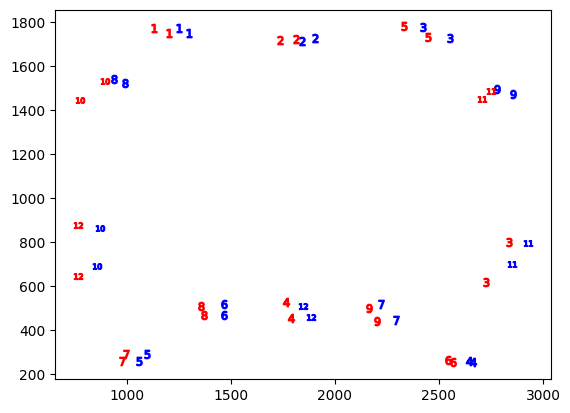

In [24]:
def plot_shape(landmarks1, landmarks2):
    for j in range(len(landmarks1)):
        i = 0
        print(f'set 1: {landmarks1[j]}')
        print(f'set 2: {landmarks2[j]}')
        for x,y in landmarks1[j]:
            i+=1
            plt.scatter(x,y, color ='red', marker="$"+str(i)+"$")
        i = 0
        for x,y in landmarks2[j]:
            i+=1
            plt.scatter(x+100,y, color = 'blue', marker="$"+str(i)+"$")
        if j == 1:
            break
plot_shape(pred_landmarks, real_landmarks)

In [25]:
x_pred,y_pred = get_xy(pred_landmarks)
x_real,y_real = get_xy(real_landmarks)

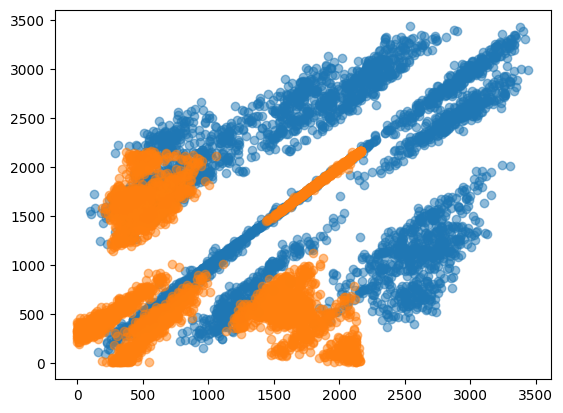

In [26]:

plt.scatter(x_pred, x_real, alpha = 0.5)
plt.scatter(y_pred, y_real, alpha = 0.5)

Tiene pinta de que estan ordenadas diferente las landmarks

In [27]:


def determine_optimal_reordering(set1, set2):
    # Calculate the pairwise distance matrix
    distance_matrix = np.linalg.norm(set1[:, np.newaxis] - set2, axis=2)

    # Use the Hungarian algorithm to find the optimal assignment
    row_indices, col_indices = linear_sum_assignment(distance_matrix)

    return col_indices

def calculate_all_errors(real_shapes, measured_shapes, optimal_order):
    errors = []
    
    for real_shape, measured_shape in zip(real_shapes, measured_shapes):
        reordered_measured_shape = measured_shape[optimal_order]
        error = calculate_errors(real_shape, reordered_measured_shape)
        errors.append(error)
    
    return errors

def calculate_errors(real_coords, estimated_coords):
    errors = np.linalg.norm(real_coords - estimated_coords, axis=1)
    
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(errors)
    max_error = np.max(errors)
    std_dev = np.std(errors)

    return {
        'Euclidean Distances': errors,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'Max Error': max_error,
        'Std Dev': std_dev
    }
    



In [29]:
# Determine the optimal reordering using the first shape pair
optimal_order = determine_optimal_reordering(real_landmarks[0], pred_landmarks[0])

# # Calculate the errors for all shapes using the optimal reordering
# errors = calculate_errors(real_landmarks, pred_landmarks, optimal_order)

# # Print the results
# error_list = []
# j = 0
# for i, error in enumerate(errors):
#     error_list.append(float(error.mean()))
#     # print(f"Shape {i+1} errors: {error}")
#     # print(f"Total error for Shape {i+1}: {error.mean()}")
#     # if i > 5:
#     #     break

# mean = statistics.mean(error_list)
# len(error_list), print(mean)

Mp soy capaz de reproducir el error: /Users/luciamf/Desktop/Landmarks_generator/example/all_data.xml MAE of the model: /Users/luciamf/Desktop/Landmarks_generator/example/carabus_1.dat is 15.267509845362888, vs 17.24959321975782

In [47]:
from reorganize_coor import reorganize_all

sort_pred_landmarks = reorganize_all(real_landmarks, pred_landmarks)

errors = calculate_all_errors(real_landmarks, pred_landmarks, optimal_order)

mae = []
mse = []
for e in errors:
    mae.append(e['MAE'])
    mse.append(e['RMSE'])
mean_mae = statistics.mean(mae)
print(f'mae: {mean_mae}')

std_dev = np.std(mae)
print(std_dev)

mean_mse = np.mean(np.array(mae)**2)
print(f'mse: {mean_mse}')

rmse = np.sqrt(mean_mse)
print(rmse)
    
    # for key, value in e.items():
    #     print(key, value)
        


mae: 17.24959321975782
19.206515911653536
mse: 666.4387197117155
25.815474423525814


In [ ]:
len(sort_pred_landmarks), len(pred_landmarks)


(319, 319)

In [ ]:
x_pred,y_pred = get_xy(list(sort_pred_landmarks))

x_real,y_real = get_xy(real_landmarks)

len(x_pred), len(x_real)

(3828, 3828)

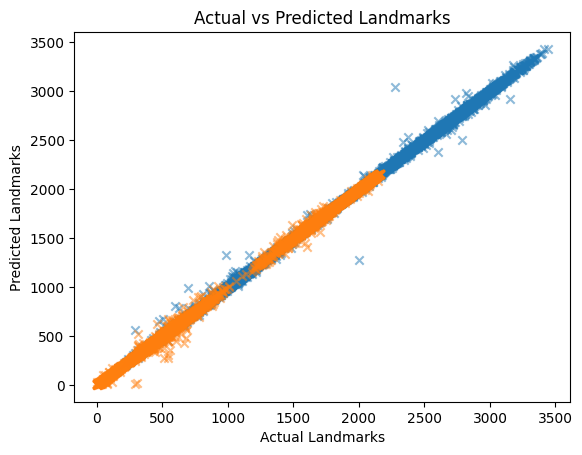

In [ ]:
plt.scatter(x_pred, x_real, alpha = 0.5, marker ='x')
plt.scatter(y_pred, y_real, alpha = 0.5, marker='x')
plt.xlabel('Actual Landmarks')
plt.ylabel('Predicted Landmarks')
plt.title('Actual vs Predicted Landmarks')
plt.show()

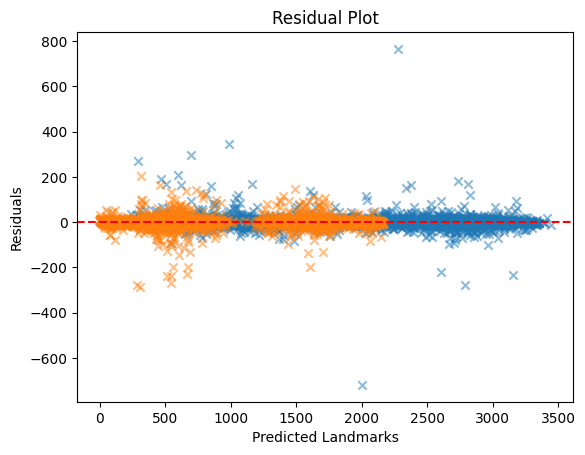

In [ ]:
x_residuals = np.array(x_real) - np.array(x_pred)
y_residuals = np.array(y_real) - np.array(y_pred)
plt.scatter(x_pred, x_residuals, alpha = 0.5, marker ='x')
plt.scatter(y_pred, y_residuals, alpha = 0.5, marker ='x')
plt.xlabel('Predicted Landmarks')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [49]:
def calculate_normalized_errors(real_coords, estimated_coords):
    # Calculate Euclidean distances (errors) between corresponding points
    errors = np.linalg.norm(real_coords - estimated_coords, axis=1)
    
    # Calculate the range of the real coordinates (maximum distance between any two points)
    max_distance = np.max(np.linalg.norm(real_coords[:, np.newaxis] - real_coords, axis=2))
    
    # Normalize the errors by the range
    normalized_errors = errors / max_distance

    return {
        'Euclidean Distances': errors,
        'Normalized Errors': normalized_errors,
        'Max Distance': max_distance
    }

In [51]:
errors = calculate_normalized_errors(real_landmarks[0], sort_pred_landmarks[0])

all_errors = []
for key, value in errors.items():
    if key == 'Normalized Errors':
        all_errors.append(value)
    print(f"{key}: {value}")

mean_error = np.mean(np.array(all_errors))
print(mean_error)

Euclidean Distances: [ 21.37755833   7.61577311   6.32455532   4.12310563  18.02775638
  15.          48.46648326 110.13627922  55.75840744  47.38143096
  85.16454661  21.9317122 ]
Normalized Errors: [0.01001666 0.00356844 0.00296343 0.00193192 0.00844708 0.00702839
 0.02270944 0.05160541 0.02612614 0.02220103 0.03990467 0.01027631]
Max Distance: 2134.200084340735
0.017231577445543222


In [53]:
def calculate_mean_relative_error(real_coords, estimated_coords):
    # Calculate Euclidean distances (errors) between corresponding points
    errors = np.linalg.norm(real_coords - estimated_coords, axis=1)
    
    # Calculate magnitudes of the real coordinates
    magnitudes = np.linalg.norm(real_coords, axis=1)
    
    # Calculate relative errors
    relative_errors = errors / magnitudes
    
    # Calculate Mean Relative Error
    mean_relative_error = np.mean(relative_errors)

    return mean_relative_error

mre = calculate_mean_relative_error(real_landmarks[0], sort_pred_landmarks[0])
print(mre)

0.01975090102230051
